In [ ]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from src.main.models.transformers import Transformer
from config import config
from src.main.pipeline.functions import clean_text, stop_words_removal
from src.main.utilities.utils import get_dataset, split_train_val_test
import numpy as np

inputs, targets = get_dataset(one_hot=False)

checkpoint = "textattack/bert-base-uncased-ag-news"

training_args = {
    'output_dir': config.RESULTS_DIRECTORY.format(checkpoint),
    'num_train_epochs': 5,
    'per_device_train_batch_size': 8,
    'per_device_eval_batch_size': 8,
    'learning_rate': 2e-5,
    'warmup_steps': 500,
    'weight_decay': 0.015,
    'logging_dir': config.LOGS_PATH.format(checkpoint),
    'logging_steps': 500,
    'evaluation_strategy': 'epoch',
    'save_strategy': 'epoch',
    'load_best_model_at_end': True,
    'metric_for_best_model': 'accuracy'
}

ag_newsBert = Transformer(checkpoint=checkpoint, **training_args)
ag_newsBert.pipeline = [clean_text, stop_words_removal]
inputs = ag_newsBert.run_pipeline(inputs, save=True)
targets = np.vectorize(config.label2id.get)(targets)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-ag-news and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/75407 [00:00<?, ? examples/s]

Map:   0%|          | 0/21546 [00:00<?, ? examples/s]

Map:   0%|          | 0/10773 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.378200,0.353955,0.892648,0.859081,0.840431,0.847774
2,0.298800,0.410350,0.897614,0.877512,0.834700,0.852951
3,0.234000,0.518355,0.898450,0.866035,0.851000,0.857268
4,0.122100,0.619512,0.896408,0.856944,0.855747,0.856319
5,0.052000,0.735130,0.895804,0.861538,0.850445,0.855466


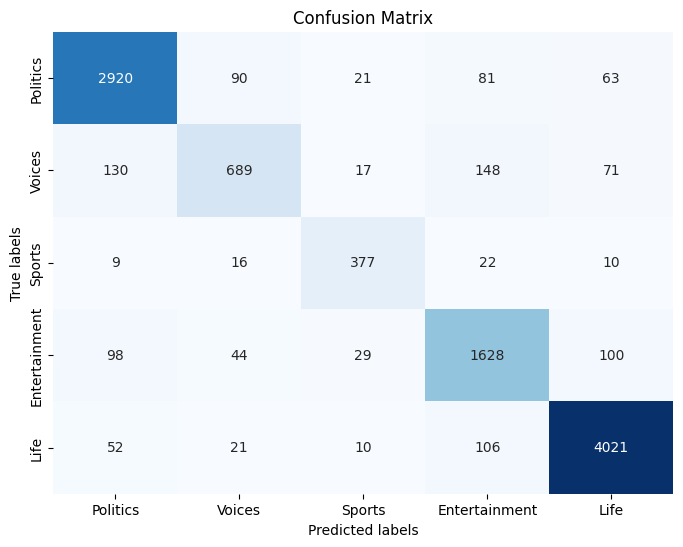

In [3]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test(inputs, targets, validation_size=0.2, test_size=0.1)

training_dataset, validation_dataset, test_dataset = (
    ag_newsBert.prepare_dataset(x_train, y_train, x_val, y_val, x_test, y_test)
)
ag_newsBert.fit(training_dataset, validation_dataset)

ag_newsBert.save_results(test_dataset)
ag_newsBert.save_model()